# Assign Atmospheric Rivers to clusters

Step 4 of Atmospheric River series. Assign anomalous atmospheric rivers to clusters based on time, and get the
anomly composites for the regimes.

1. Read in AR data and total k clusters
    * Input atmospheric river totals:
        - metis: `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.nc`
    * Input atmospheric river anomalies: 
        - metis: `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.anoms.nc`
       
    * Input: total clusters metis: 
        - `/glade/work/mkorendy/metisregimes/resolution/metis.z500_u250_pna_months_lpfilter_twicedaily_10days.tot.1986-2016.nc`
2. Assign AR to clusters
    
    * Output: `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.k5.clustering.nc`
    
3. Make composites of the clusters! Huzzah
    * Output anomaly composites: 
        - `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.k5.anom_composite.nc`
    * Output image:
        - `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.k5.composite.png`

## Constants

In [1]:
# Data information
res = '199'
era5 = False
months = 'NDJFM'

# Moisture flux magnitude information
threshold = '10%'
crit_val = 259.0

# Number of regimes
k = 5

## Imports

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.mpl.ticker as cticker
from sklearn import metrics

## Files

In [3]:
# Path
if res == '199' or era5 == True:
    path = '/glade/work/mkorendy/metisregimes/'
else:
    path = '/glade/work/mkorendy/metisregimes/tco' + res + '/'
    
# Input and output
if era5 == False:
    
    # Atmospheric river totals
    if res != '1279':
        f_tot = path + 'metis' + res + '.AR.' + threshold + '.PNA.NDJFM.nc'
    else:
        f_tot = path + 'metis' + res + '.AR.' + threshold + '.PNA.ND.nc'
    
    #Atmospheric river anomalies
    if res != '1279':
        f_ar = path + 'metis' + res + '.AR.' + threshold + '.PNA.NDJFM.anoms.nc'
    else:
        f_ar = path + 'metis' + res + '.AR.' + threshold + '.PNA.ND.anoms.nc'
    
    #k=5 cluster file
    f_clust = path + 'metis.z500_u250_pna_' + months + '_lpfilter_twicedaily_10days.tot.k' + str(k) + '.1986-2016.nc'
    
    #Cluster output
    f_clust_out = path + 'metis' + res + '.AR.' + threshold + '.PNA.' + months + '.k' + str(k) + '.clustering.nc'
    
    # Composite output
    f_comp = path + 'metis' + res + '.AR.' + threshold + '.PNA.' + months + '.k' + str(k) + '.composite.nc'
    
    # Picture output
    f_pic = 'metis' + res + '.AR.' + threshold + '.PNA.' + months + '.k' + str(k) + '.composite.png'

else:
    # ERA5
    
    # Atmospheric river totals
    f_tot = path + 'era5.AR.' + threshold + '.PNA.NDJFM.nc'
    
    # Atmospheric river anomalies
    f_ar = path + 'era5.AR.' + threshold + '.PNA.NDJFM.anoms.nc'
    
    # k=5 cluster file
    f_clust = path + 'era5.z500_u250_pna_' + months + '_lpfilter_twicedaily_10days.tot.k' + str(k) + '.1986-2016.nc'
    
    #Cluster output
    f_clust_out = path + 'era5.AR.' + threshold + '.PNA.' + months + '.k' + str(k) +'.clustering.nc'
    
    # Composite output
    f_comp = path + 'era5.AR.' + threshold + '.PNA.' + months + '.k' + str(k) +'.composite.nc'
    
    # Picture output
    f_pic = 'era5.AR.' + threshold + '.PNA.' + months + '.k' + str(k) +'.composite.png'

# Get filtered times for ND
if months == 'ND':
    f_times = '/glade/work/mkorendy/metisregimes/tco1279/metis.z500_pna_ND_lpfilter_twicedaily_10days.1986-2016.anoms.nc'

In [4]:
print(f_tot)
print(f_ar)
print(f_clust)
print(f_comp)
print(f_pic)
print(f_clust_out)

/glade/work/mkorendy/metisregimes/metis199.AR.10%.PNA.NDJFM.nc
/glade/work/mkorendy/metisregimes/metis199.AR.10%.PNA.NDJFM.anoms.nc
/glade/work/mkorendy/metisregimes/metis.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.tot.k5.1986-2016.nc
/glade/work/mkorendy/metisregimes/metis199.AR.10%.PNA.NDJFM.k5.composite.nc
metis199.AR.10%.PNA.NDJFM.k5.composite.png
/glade/work/mkorendy/metisregimes/metis199.AR.10%.PNA.NDJFM.k5.clustering.nc


## Read data in

In [5]:
# Atmospheric river total
ds_tot = xr.open_dataset(f_tot)
    
#Atmospheric river time series
ds_anoms = xr.open_dataset(f_ar)
    
# k=5 cluster time series
ds_clust = xr.open_dataset(f_clust)

if months == 'ND':
    ds_times = xr.open_dataset(f_times)

### For river totals, replace numbers with 1 and nans with 0 for easier counting

In [6]:
da_river = np.nan_to_num(ds_tot.river.values)
da_river = np.where(da_river == 0, 0, 1)

In [7]:
da_river.shape

(204000, 22, 53)

In [8]:
if era5 == False:
    ds_tot = xr.DataArray(da_river.reshape((len(ds_anoms.ensemble), len(ds_anoms.time),22,53)), 
                         coords={'ensemble':ds_anoms.ensemble.values, 'time':ds_anoms.time.values, 
                             'lat':ds_tot['lat'].values, 'lon':ds_tot['lon'].values},
                             dims=['ensemble','time', 'lat', 'lon']).to_dataset(name='river')
else:
    ds_tot = xr.DataArray(da_river.reshape(len(ds_tot.time),22,53), 
                         coords={'time':ds_tot.time.values, 
                             'lat':ds_tot['lat'].values, 'lon':ds_tot['lon'].values},
                             dims=['time', 'lat', 'lon']).to_dataset(name='river')

In [9]:
# Transpose river total ensemble and time dimensions to match with anomalies and clustering
if era5 == False:
    ds_tot = ds_tot.transpose('time','ensemble','lat','lon')

In [10]:
if len(ds_tot.time) != len(ds_anoms.time):
    ds_tot = ds_tot.sel(time=ds_anoms.time)

### If necessary, select ND times

In [11]:
if months == 'ND' and res != '1279':
    ds_tot = ds_tot.sel(time=ds_times.time)
    ds_anoms = ds_anoms.sel(time=ds_times.time)

### Select the first 15 ensembles of metis for ND times

In [12]:
if era5 == False and months == 'ND' and res != '1279':
    ds_tot = ds_tot.sel(ensemble = ds_times.ensemble)
    ds_anoms = ds_anoms.sel(ensemble = ds_times.ensemble)

## Flatten metis ensemble data, and replace the time coordinate with the cluster assignments

In [13]:
if era5 == False:
    ds_tot = xr.DataArray(ds_tot.river.values.reshape((len(ds_anoms.ensemble) * len(ds_anoms.time),22,53)), 
                     coords={'cluster':ds_clust['k' + str(k)].values, 
                             'lat':ds_tot['lat'].values, 'lon':ds_tot['lon'].values},
                             dims=['cluster', 'lat', 'lon']).to_dataset(name='river_tot')
    ds_anoms = xr.DataArray(ds_anoms.river.values.reshape((len(ds_anoms.ensemble) * len(ds_anoms.time),22,53)), 
                     coords={'cluster':ds_clust['k' + str(k)].values, 
                             'lat':ds_tot['lat'].values, 'lon':ds_tot['lon'].values},
                             dims=['cluster', 'lat', 'lon']).to_dataset(name='river_anoms')
else:
    # Rename time dimension to cluster
    ds_tot = ds_tot.rename_dims(time='cluster')
    ds_anoms = ds_anoms.rename_dims(time='cluster')
    
    # Rename variables as appropriate
    ds_tot = ds_tot.rename(river = 'river_tot')
    ds_anoms = ds_anoms.rename(river = 'river_anoms')
    
    # Set cluster values as cluster values
    ds_tot['cluster'] = ds_clust['k' + str(k)].values
    ds_anoms['cluster'] = ds_clust['k' + str(k)].values

In [14]:
#ds_tot

In [16]:
## Write clustering to file
(xr.merge([ds_tot,ds_anoms])).to_netcdf(f_clust_out)

## Compute regime composites

In [17]:
# Group by cluster, then take the sum of each group
# Get total number of occurrences in each regime
tot_comp = ds_tot.groupby('cluster').sum()
anom_comp = ds_anoms.groupby('cluster').sum()

### Merge the datasets into one

In [18]:
ds = xr.merge([tot_comp,anom_comp])

### Write the composite to file

In [19]:
ds.to_netcdf(f_comp)

## Scale the metis data by ensemble

In [20]:
if era5 == False and months == 'NDJFM':
    ds = ds/25
elif era5 == False and months == 'ND':
    ds = ds/15

## Plot the cluster composites

In [21]:
max(ds.river_tot.values.flatten())

35.04

In [22]:
#ds.river_anoms[1][:,:]=0.0

In [23]:
# Set titles
if k == 5:
    if months == 'NDJFM':
        if era5 == False:
            if res == '199':
                titles = ['Pacific Trough', 'Pacific Wavetrain', 'Arctic High', 'Arctic Low', 'Alaskan Ridge']
            elif res == '639':
                titles = ['Pacific Trough', 'Arctic High', 'Pacific Wavetrain', 'Arctic Low', 'Alaskan Ridge']
        else:
            titles = ['Pacific Wavetrain', 'Arctic Low', 'Pacific Trough', 'Arctic High', 'Alaskan Ridge']
    else:
        if era5 == True:
            titles = ['Alaskan Ridge', 'Arctic Low','Pacific Trough', 'Pacific Wavetrain','Arctic High']
        elif res == '199':
            titles = ['Hybrid Pacific Wavetrain/Pacific Trough', 'Alaskan Ridge/Arctic Low', 
                  'Hybrid Pacific Wavetrain/Alaskan Ridge', 'Arctic High', 'Pacific Trough']
        elif res == '639':
            titles = ['Pacific Trough', 'Alaskan Ridge', 'Pacific Wavetrain', 'Arctic High', 'Arctic Low']
        else:
            titles = ['Pacific Trough', 'Hybrid Pacific Trough/Arctic Low',
                     'Hybrid Pacific Wavetrain/Alaskan Ridge', 'Arctic High', 'Hybrid Alaskan Ridge/Arctic Low']
elif k == 4:
    # Set cluster titles
    if months != 'ND' and era5 == True:
        titles=['Arctic Low','Pacific Trough','Alaskan Ridge', 'Pacific Wavetrain']
    elif months == 'NDJFM' and era5 == False:
        if res == '199':
            titles = ['Hybrid Alaskan Ridge/Arctic Low (0)', 'Hybrid Pacific Wavetrain/Pacific Trough (1)',
                     'Hybrid Pacific Trough/Arctic Low (2)', 'Hybrid Alaskan Ridge/Pacific Wavetrain (3)']
        elif res == '639':
            titles = ['Hybrid Arctic Low/Pacific Trough', 'Hybrid Pacific Trough/Pacific Wavetrain',
                     'Alaskan Ridge', 'Hybrid Pacific Wavetrain/Alaskan Ridge']
    elif months == 'ND' and era5 == True:
        titles = ['Pacific Wavetrain', 'Alaskan Ridge', 'Arctic Low', 'Pacific Trough']
    elif months == 'ND' and era5 == False:
        if res == '199':
            titles = ['Hybrid Arctic Low/Pacific Trough', 'Hybrid Pacific Wavetrain/Alaskan Ridge',
                             'Hybrid Alaskan Ridge/Arctic Low', 'Pacific Trough']
        if res == '639':
            titles = ['Arctic Low', 'Pacific Trough', 'Pacific Wavetrain', 'Alaskan Ridge']
        if res == '1279':
            titles = ['Hybrid Pacific Wavetrain/Alaskan Ridge', 'Hybrid Alaskan Ridge/Arctic Low', 
                              'Hybrid Pacific Trough/Arctic Low', 'Pacific Trough']

In [24]:
# Set map information
cm = 220
proj = ccrs.EquidistantConic(central_longitude=cm)
minlon = -70 + cm
maxlon = +60 + cm
lat_labels=np.arange(20,90,20)
lon_labels=np.arange(150,330,30)
extent=[minlon,maxlon,10,90]

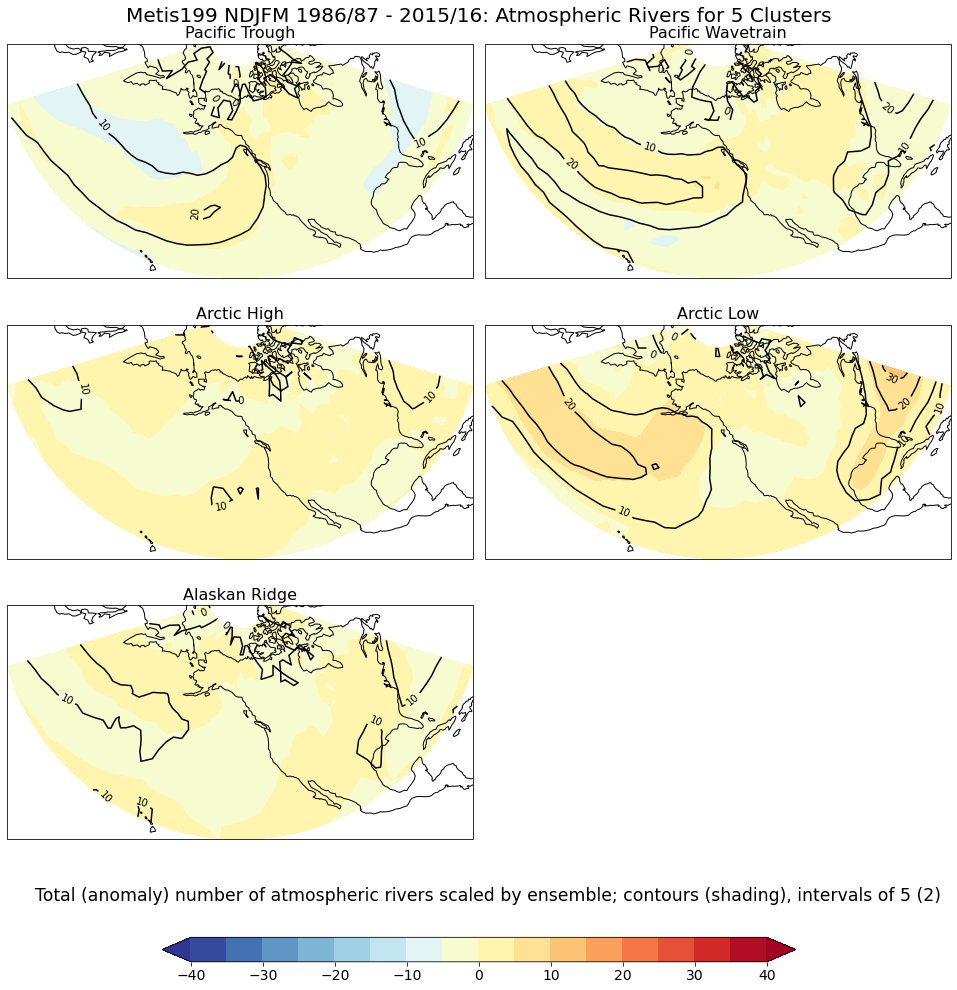

In [27]:
#Plot the figure

cm = 225
minlon = -70 + cm
maxlon = 80 + cm


if k == 5: 
    if era5 == False:
        if months == 'NDJFM':
            clevs=np.arange(-40,45,5)
            levs=np.arange(0,100,10)
        else:
            clevs=np.arange(-8,10,2)
            levs=np.arange(0,25,5)
    else:
        if months == 'NDJFM':
            clevs = np.arange(-8,10,2)
            levs = np.arange(0,25,5)
        else:
            clevs = np.arange(-8,9,1)
            levs = np.arange(0,18,2)

elif k == 4:
    
    if months == 'NDJFM':
        clevs = np.arange(-16,18,2)
        levs = np.arange(0,40,5)
    else:
        clevs = np.arange(-8,9,1)
        levs = np.arange(0,18,2)
        
#clevs=[-12,-10,-9,-6,-3,0,3,6,9,10,12]
data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)
#proj = ccrs.PlateCarree(central_longitude=cm)
fig,axs=plt.subplots(3,2,subplot_kw={'projection':proj},figsize=(22,17))


for i,ax in enumerate(axs.flatten()):
        #ax.set_extent(extent)
    if (i < k):
        cs=ax.contourf(ds['lon'],ds['lat'],
                           ds.river_anoms[i] + 1e-100,clevs,
                           transform=ccrs.PlateCarree(),
                           cmap='RdYlBu_r', extend='both')
        cs2=ax.contour(ds['lon'],ds['lat'],
                       ds.river_tot[i],levs,
                           colors='k',
                       transform=ccrs.PlateCarree())
        ax.clabel(cs2,fmt='%2d')
        ax.set_title(titles[i],fontdict={'fontsize':16})
        #ax.gridlines()
        ax.coastlines()

fig.delaxes(axs.flatten()[5])

if k == 4:
    fig.delaxes(axs.flatten()[4])

if era5 == True:
    plt.suptitle('ERA5 ' + months + ' 1986/87 - 2015/16: ' + str(k) +' Clusters',fontsize=20)
else: 
    plt.suptitle('Metis' + res + ' ' + months + ' 1986/87 - 2015/16: Atmospheric Rivers for '
                  + str(k) + ' Clusters',fontsize=20)

# Add Colorbar
fig.subplots_adjust(bottom=0.3, top=0.95, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)

if k == 5:
    cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.02])
elif k == 4:
    cbar_ax = fig.add_axes([0.3, 0.45, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14) 

if k == 5:
    figtxt_x = .25
    con_int = .5
else:
    figtxt_x = .49
    con_int = 1
    
if era5 == False:
    if months == 'NDJFM':
        plt.figtext(.22,figtxt_x,'Total (anomaly) number of atmospheric rivers scaled '
                        + 'by ensemble; contours (shading), intervals of 5 (2)',
                        fontsize='xx-large')
    else:
        plt.figtext(.22,figtxt_x,'Total (anomaly) number of atmospheric rivers scaled '
                        + 'by ensemble; contours (shading), intervals of 2 ('+ str(con_int) + ')',
                    fontsize='xx-large')
else:
    if months == 'NDJFM':
        plt.figtext(.26,figtxt_x,'Total (anomaly) number of atmospheric rivers; contours (shading), intervals of 5 (2)',
                    fontsize='xx-large')
    else:
        plt.figtext(.26,figtxt_x,'Total (anomaly) number of atmospheric rivers; contours (shading), intervals of 2 (' + str(con_int) + ')',
                    fontsize='xx-large')
        
plt.savefig(f_pic)